In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 
import torch.nn.functional as F
from torchvision.utils import make_grid

In [2]:
means = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)

train_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize(means, std)])

test_transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize(means, std)])



In [3]:
num_epochs = 25
batch_size = 4
learning_rate = 0.001

In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=True,
                                        download=True, transform=train_transform)

test_dataset = torchvision.datasets.CIFAR10(root='cifar-10-batches-py', train=False,
                                       download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
                                          

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

170499072it [00:08, 19822716.63it/s]                               


Extracting cifar-10-batches-py/cifar-10-python.tar.gz to cifar-10-batches-py
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


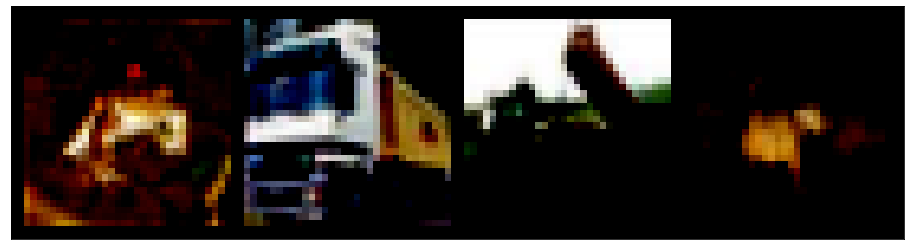

In [6]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [8]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.Linear

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        nn.ReLU()
        # using a 2x2 grid as a filter 
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)
        nn.ReLU()
        nn.Flatten()
        self.fc1 = nn.Linear(400, 120)

        self.fc2 = nn.Linear(120, 84)

        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 16 * 5 * 5)            
        x = F.relu(self.fc1(x))               
        x = F.relu(self.fc2(x))               
        x = self.fc3(x)                       
        return x

In [10]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [11]:
def difference(arr):
    return [item-arr[i-1] for i, item in enumerate(arr) if i != 0]



In [12]:
n_total_steps = len(train_loader)
train_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for i, (data, target) in enumerate(train_loader):
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        data = data.to(device)
        target = target.to(device)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
 
        # Backward and optimize
        loss.backward()
        optimizer.step()

        #clearing the gradient so we dont have any uneccesary 
        optimizer.zero_grad()


        train_loss+=loss.item() * data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)   

    #if len(train_losses) > 6:
     #   newList = difference(train_losses)
      #  tot_sum = 0
       # for i in range(newList):
        #    tot_sum+=i
        #if(tot_sum/5) <= 0.01:
         #   break
        
 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch + 1, train_loss))
      

Epoch: 1 	Training Loss: 2.221085
Epoch: 2 	Training Loss: 1.842187
Epoch: 3 	Training Loss: 1.622500
Epoch: 4 	Training Loss: 1.515227
Epoch: 5 	Training Loss: 1.439988
Epoch: 6 	Training Loss: 1.374014


TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
model.eval()
with torch.no_grad():
    n_of_correct = 0
    n_of_samples = 0
    n_of_class_correct = [0 for i in range(len(classes))]
    n_of_class_samples = [0 for i in range(len(classes))]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_of_samples += labels.size(0)
        n_of_correct += (predicted == labels).sum().item()

    total_acc = 100.0 * n_of_correct / n_of_samples 
    print(f'average accuracy {total_acc}')
    





average accuracy 64.03


In [ ]:
torch.save(model.state_dict(), 'model.ckpt')

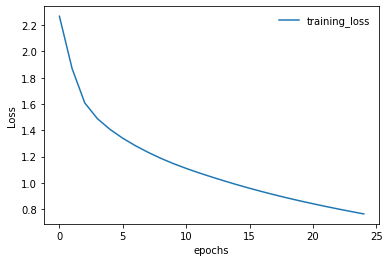

In [ ]:
plt.plot(train_losses, label = 'training_loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(frameon = False)